# Import Modules

In [ ]:
import torch
from torch import nn
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pandas as pd
import os
from torch.utils.data import dataset, dataloader
from torchvision import datasets, models, transforms
import torchvision.transforms as transforms
import sklearn
import timm
from torchsummary import summary
from pathlib import Path
from PIL import Image
import random
import shutil
from sklearn.model_selection import train_test_split
import torchinfo
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from torch.optim.lr_scheduler import ReduceLROnPlateau
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
import cv2
import gradio as gr
from IPython.display import Markdown, display
import io
import base64
from dotenv import load_dotenv
from groq import Groq


In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device", device)

Using device cpu


In [53]:
model = timm.create_model('xception', pretrained=True, num_classes=2)

c:\NTU\Modules\Y1S2\CC0002\Codes\venv\Lib\site-packages\timm\models\_factory.py:126: UserWarning: Mapping deprecated model name xception to current legacy_xception.
  model = create_fn(


In [54]:
model.load_state_dict(torch.load("trained_model.pth", map_location="cpu"))

<All keys matched successfully>

In [55]:
model.eval()

Xception(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): ReLU(inplace=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), bias=False)
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act2): ReLU(inplace=True)
  (block1): Block(
    (skip): Conv2d(64, 128, kernel_size=(1, 1), stride=(2, 2), bias=False)
    (skipbn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (rep): Sequential(
      (0): SeparableConv2d(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=64, bias=False)
        (pointwise): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      )
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): SeparableConv2d(
        (conv1): Conv

In [6]:
train_transforms = transforms.Compose([
    transforms.Resize((299, 299)),        # e.g., for Inception-like networks
    transforms.RandomHorizontalFlip(),    # flips half the images horizontally
    transforms.RandomRotation(10),        # random rotation ±10 degrees
    transforms.ToTensor(),                # convert to PyTorch
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

test_transforms = transforms.Compose([
    transforms.Resize((299, 299)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

In [7]:
train_dir = os.path.join(os.getcwd(), "images", "train")
test_dir = os.path.join(os.getcwd(), "images", "test")

In [8]:
# Create Dataset objects
train_dataset = datasets.ImageFolder(root=train_dir, transform=train_transforms)
test_dataset  = datasets.ImageFolder(root=test_dir, transform=test_transforms)

# Create DataLoaders
batch_size = 32
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader  = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"Train samples: {len(train_dataset)}, Test samples: {len(test_dataset)}")

Train samples: 126000, Test samples: 14000


## Testing

In [9]:
testing = next(iter(test_loader))

In [10]:
predict = model(testing[0])

In [11]:
result = torch.argmax(predict, dim=1)

In [12]:
correct = (result == testing[1])

In [13]:
correct = correct.sum().item()

In [ ]:
correct / 32

# Test Custom Images

## Use torch.datasets

In [9]:
test_dataset

Dataset ImageFolder
    Number of datapoints: 14000
    Root location: c:\NTU\Modules\Y1S2\CC0002\Codes\images\test
    StandardTransform
Transform: Compose(
               Resize(size=(299, 299), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

In [10]:
image, label = test_dataset[0]

In [11]:
image.shape

torch.Size([3, 299, 299])

In [12]:
std = [0.229, 0.224, 0.225]
mean = [0.485, 0.456, 0.406]

In [13]:
from torchvision.transforms.functional import to_pil_image

# Unnormalize (if it was normalized)
img = image * std + mean

# Convert to PIL and show
img_pil = to_pil_image(img)
img_pil.show()


TypeError: only integer tensors of a single element can be converted to an index

## Use image directly

C:\Users\Parvez\AppData\Local\Temp\ipykernel_25552\2560935832.py:19: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  fake_percentage = torch.nn.functional.softmax(fake_pred_softmax)[0][1]
C:\Users\Parvez\AppData\Local\Temp\ipykernel_25552\2560935832.py:20: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  true_percentage = torch.nn.functional.softmax(true_pred_softmax)[0][1]


Fake image prediction: Fake Image, probability: 0.9186
True image prediction: Real Image, probability: 0.4974


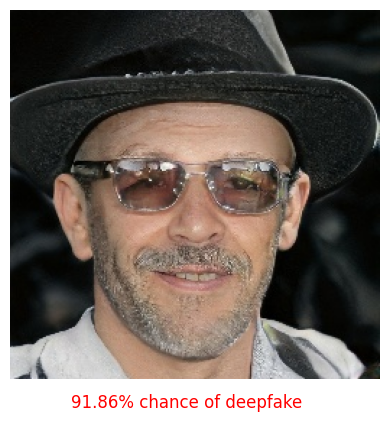

(np.float64(-0.5), np.float64(255.5), np.float64(255.5), np.float64(-0.5))

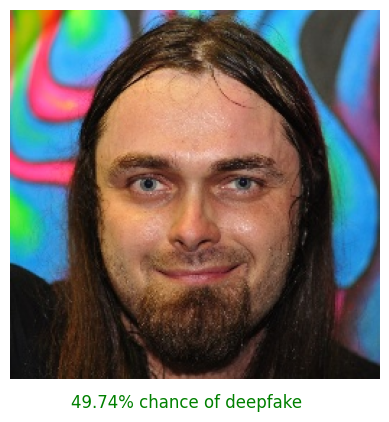

In [56]:
fake_name = "CTIOWLI3P1"

fake_folder = os.path.join(test_dir, "..", "..", "DeepFakeDetection", "DeepFakeDetection", "fake")
true_folder = os.path.join(test_dir, "..", "..", "DeepFakeDetection", "DeepFakeDetection", "real")
fake_img_path = os.path.join(fake_folder, f"{fake_name}.jpg")
true_img_path = os.path.join(true_folder, "00040.jpg")

fake_img = Image.open(fake_img_path)
true_img = Image.open(true_img_path)

fake_tensor = test_transforms(fake_img).to(device).unsqueeze(0)
true_tensor = test_transforms(true_img).to(device).unsqueeze(0)

with torch.no_grad():
    fake_pred_softmax = model(fake_tensor)
    fake_pred = fake_pred_softmax.argmax(dim=1).item()
    true_pred_softmax = model(true_tensor)
    true_pred = true_pred_softmax.argmax(dim=1).item()
fake_percentage = torch.nn.functional.softmax(fake_pred_softmax)[0][1]
true_percentage = torch.nn.functional.softmax(true_pred_softmax)[0][1]
print(f"Fake image prediction: {"Fake Image" if fake_pred else "Real Image"}, probability: {fake_percentage:.4f}")
print(f"True image prediction: {"Fake Image" if true_pred else "Real Image"}, probability: {true_percentage:.4f}")


plt.imshow(fake_img)
plt.figtext(0.5, 0.05, f"{fake_percentage:.2%} chance of deepfake", ha="center", fontsize=12, color='red')
plt.axis('off')
plt.show()

plt.imshow(true_img)
plt.figtext(0.5, 0.05, f"{true_percentage:.2%} chance of deepfake", ha="center", fontsize=12, color='green')
plt.axis('off')


## Implementing Grad-CAM

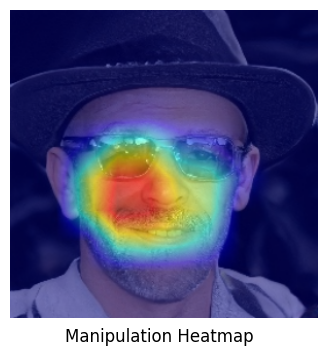

In [57]:
target_layer = model.conv4
cam = GradCAM(model=model, target_layers=[target_layer])
target_category = 1  # Assuming '1' corresponds to "fake"; adjust as necessary

# Create a target for the specified category
targets = [ClassifierOutputTarget(target_category)]

# Generate the CAM
grayscale_cam = cam(input_tensor=fake_tensor, targets=targets)
grayscale_cam = grayscale_cam[0, :]  # Get the CAM for the first (and only) image
fake_img_cv2 = cv2.imread(fake_img_path, cv2.IMREAD_COLOR)
fake_img_rgb = cv2.cvtColor(fake_img_cv2, cv2.COLOR_BGR2RGB)
fake_img_float = fake_img_rgb.astype(np.float32) / 255.0
fake_img_float = cv2.resize(fake_img_float, (299, 299))
cam_image = show_cam_on_image(fake_img_float, grayscale_cam, use_rgb=True)

plt.figure(figsize=(4,4))
plt.axis('off')
plt.figtext(0.5, 0.05, "Manipulation Heatmap", ha="center", fontsize=12, color='black')
plt.imshow(cam_image)


# Using LLM

In [13]:
model = "llama-3.2-11b-vision-preview"

In [ ]:
load_dotenv()
api_key = os.getenv("GROQ_API_KEY")

In [16]:
client = Groq(
    api_key=api_key,
)

In [32]:
# Define image encoding function
def encode_image(image_path):
  with open(image_path, "rb") as image_file:
    return base64.b64encode(image_file.read()).decode('utf-8')

base64_image = encode_image(fake_img_path)

In [ ]:
def llm_image(base64_image):
    chat_completion = client.chat.completions.create(
    messages=[
        {
            "role": "user",
            "content": [
                {
                    "type": "image_url",
                    "image_url": {
                        "url": f"data:image/jpeg;base64,{base64_image}",
                    },
                },
                {"type": "text", "text": "You are a deepfake image analyzer. An image and its corresponding heatmap are provided, with the heatmap highlighting the areas most likely manipulated. In one clear, layman-friendly sentence, explain why the image appears to be a deepfake based solely on the heatmap."},
                {"type": "text", "text": "Answer in less than two sentences. Explain why rather than state the result."},
            ],
        }
    ],
    model="llama-3.2-11b-vision-preview",)
    return chat_completion.choices[0].message.content

In [33]:
base64_image = encode_image(fake_img_path)


In [34]:
img = Image.fromarray(cam_image)

In [35]:
buffered = io.BytesIO()

In [36]:
img.save(buffered, format="JPEG")

In [37]:
buffered.seek(0)

0

In [38]:
img_bytes = buffered.getvalue()

In [39]:
img_base64 = base64.b64encode(img_bytes).decode('utf-8')

In [41]:
ai_message = llm_image(img_base64)

In [43]:
display(Markdown(f"**AI:** {ai_message}"))

**AI:** The heatmap highlights a disproportionate amount of manipulation in the face and eyes region of the image. This could indicate a deepfake due to the amount of manipulation showing up in the area likely to be exploited and controlled at a high level by deepfake generators. Such heavy manipulation in this area can indicate that someone has taken control of an AI-based software, causing the program to misrepresent the visual reality by faking content near the face so that it looks more photorealistic.

# Gradio UI

In [62]:
def predict_and_explain(image: Image.Image):
    image_tensor = test_transforms(image).unsqueeze(0).to(device)
    with torch.no_grad():
        pred_softmax = model(image_tensor)
        pred = pred_softmax.argmax(dim=1).item()
        percentage = torch.nn.functional.softmax(pred_softmax)[0][1]
    
    # Generate CAM
    target_layer = model.conv4
    cam = GradCAM(model=model, target_layers=[target_layer])
    target_category = 1  # Assuming '1' corresponds to "fake"; adjust as necessary

    # Create a target for the specified category
    targets = [ClassifierOutputTarget(target_category)]

    # Generate the CAM
    grayscale_cam = cam(input_tensor=image_tensor, targets=targets)
    grayscale_cam = grayscale_cam[0, :]  # Get the CAM for the first (and only) image
    img_rgb = cv2.cvtColor(np.array(image), cv2.COLOR_BGR2RGB)
    img_float = img_rgb.astype(np.float32) / 255.0
    img_float = cv2.resize(img_float, (299, 299))
    cam_image = show_cam_on_image(img_float, grayscale_cam, use_rgb=True)
    img = Image.fromarray(cam_image)
    # Save the image into a BytesIO stream
    buffered = io.BytesIO()
    img.save(buffered, format="JPEG")  # You can choose JPEG as well
    buffered.seek(0)

    # Get the byte contents from the BytesIO buffer
    img_bytes = buffered.getvalue()

    # Encode the bytes to a base64 string
    img_base64 = base64.b64encode(img_bytes).decode('utf-8')
    ai_message = llm_image(base64_image=img_base64)
    
    return f"{percentage:.2%} chance of deepfake", cam_image, ai_message

In [84]:
demo = gr.Interface(
    fn=predict_and_explain,
    inputs=gr.Image(type="pil"),
    outputs=[
        gr.Textbox(label="Model Prediction"),
        gr.Image(label="Manipulation Heatmap"),
        gr.Textbox(label="AI Explanation")
    ],
    title="Deepfake Detection and Explanation",
    description="Upload an image to check if it's a deepfake and get an explanation of the model's prediction.",
)

In [85]:
demo.launch()

* Running on local URL:  http://127.0.0.1:7871

To create a public link, set `share=True` in `launch()`.


C:\Users\Parvez\AppData\Local\Temp\ipykernel_25552\847125636.py:6: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  percentage = torch.nn.functional.softmax(pred_softmax)[0][1]
